In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
from scipy.spatial import cKDTree
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' BDI ON',
            ' BAI OFF',
            ' BDI OFF',
            'Starkstein Apathy Off',
            ' postop bdi (on)',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))#[phys==1].astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 36] = 0
c_cases_idx[ids == 53] = 0
c_cases_idx[ids == 98] = 0
c_cases_idx[ids == 108] = 0
# Exclude infinite BDI
c_cases_idx[ids == 16] = 0
c_cases_idx[ids == 45] = 0
c_cases_idx[ids == 46] = 0
c_cases_idx[ids == 78] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,4:6,:]
#X_all_c = (np.load('X2h_sr.npy').T).reshape((31,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,4:6,:]
R_all_c = R_all[c_cases_idx,4:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' BDI OFF']-cv_dict[' postop bdi (on)'])/cv_dict[' BDI OFF'])[s_cases_idx]
pre_imp = ((cv_dict[' BDI OFF']-cv_dict[' BDI ON'])/cv_dict[' BDI OFF'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
pre_bdi = cv_dict[' BDI OFF'][s_cases_idx]
pre_sas = cv_dict['Starkstein Apathy Off'][s_cases_idx]
pre_bai = cv_dict[' BAI OFF'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
subsc = subs[s_cases_idx]
    
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping Starkstein Apathy Off
Keeping  BDI OFF
Keeping  BDI ON
Keeping  BAI OFF
Keeping  OFF (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  postop bdi (on)
{'Ethnicity', ' postop bdi (on)', 'Physician', ' BDI OFF', 'Sex', ' BDI ON', 'CORNELL ID', 'Age', ' Location', 'Race', 'Starkstein Apathy Off', ' BAI OFF', 'Disease Duration (year)', ' OFF (pre-dbs updrs)', ' pre op levadopa equivalent dose (mg)', ' Target', ' Test medication status'}
['X_115_01.npy', 'X_115_02.npy', 'X_115_03.npy', 'X_115_04.npy', 'X_115_05.npy', 'X_115_06.npy', 'X_115_07.npy', 'X_115_08.npy', 'X_115_09.npy', 'X_115_10.npy', 'X_115_100.npy', 'X_115_101.npy', 'X_115_102.npy', 'X_115_104.npy', 'X_115_105.npy', 'X_115_106.npy', 'X_115_107.npy', 'X_115_108.npy', 'X_115_109.npy', 'X_115_11.npy', 'X_115_110.npy

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide


In [4]:
m = util.exclude_outliers(per_change)
per_change = per_change[m]
subsc = subsc[m]
X_all_c = X_all_c[m,:,:]
X_all_c.shape

Upper bound of 0.7432432432432432
Lower bound of -0.44594594594594594
Excluded 6 outliers


(19, 2, 1595)

In [5]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [6]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz = []
c = 0
K_all_c = np.append(K_all_c,'pre_bdi')
for j in np.arange(c,len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    (mu, sigma) = stats.norm.fit(y_train)
    yc = -sigma
    y_cat = y_train <= yc
    idy = np.where(y_cat==1)
    # Cross validation
    # Remove LCT results
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_bdi[m],None,None,None,None,None,None,None,None,None,False,False,False)
                                                #pre_bai[m],pre_bdi[m],pre_sas[m],pre_updrs[m],tmed[m],ledd[m],age[m],dd[m],loc[m],phys[m],False,False,False)
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1

    lasso = slm.LassoLarsCV(cv=6,normalize=False,eps=0.1)
    kappa = stats.skew(y_train)
    while np.sum(y_cat) < cvn:
      np.random.seed(rs)
      idyr = np.random.choice(np.asarray(idy).ravel())
      X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      y_train = np.append(y_train,y_train[idyr])
      y_cat = y_train <= yc
      rs = rs+1
      print('Resampled to size',y_train.shape)
    if aug == True:
      np.random.seed(rs)
      y_train_n = y_train+(sigma)*np.random.normal(0,1,1)
      y_train = np.hstack((y_train,y_train_n))
      y_cat = y_train <= yc
      X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      print('Augmented to size',y_train.shape)
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,cv=cvn,step=1)#skf.SelectKBest(skf.f_regression,k=5)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        np.seterr(divide='ignore', invalid='ignore')
        lasso = slm.LassoLarsCV(cv=cvn,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
        results_ls_aug[c] = est_ls.predict(X_test_ss)
        print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'compared to LCT',pre_imp[m][c])
        K_nz.append(sel.transform(K_all_c.reshape(1,-1)))
        c=c+1


      

  


Resampled to size (19,)
Resampled to size (20,)
Augmented to size (40,)
Lasso predicts 0.2504 for case with 0.51 compared to LCT 0.425531914893617
Resampled to size (19,)
Resampled to size (20,)
Augmented to size (40,)


In [ ]:
K_nz

[array([['original_gldm_LowGrayLevelEmphas',
         'original_gldm_SmallDependenceEmp',
         'original_gldm_SmallDependenceHig',
         'original_gldm_SmallDependenceLow',
         'original_glrlm_GrayLevelNonUnifo',
         'original_glrlm_GrayLevelNonUnifo',
         'original_glrlm_GrayLevelVariance',
         'original_glrlm_HighGrayLevelRunE',
         'original_glrlm_LongRunEmphasis',
         'original_glrlm_LongRunHighGrayLe',
         'original_glrlm_LongRunLowGrayLev',
         'original_glrlm_LowGrayLevelRunEm',
         'wavelet-LLH_glszm_LowGrayLevelZo',
         'wavelet-HLH_glszm_SmallAreaEmpha',
         'wavelet-HLH_glszm_SmallAreaHighG',
         'wavelet-HLH_glszm_SmallAreaLowGr',
         'wavelet-HLH_glszm_ZoneEntropy',
         'wavelet-HLH_glszm_ZonePercentage',
         'wavelet-HLH_glszm_ZoneVariance', 'wavelet-HLH_ngtdm_Busyness',
         'wavelet-HLH_ngtdm_Coarseness',
         'wavelet-HHH_firstorder_Interquar',
         'wavelet-HHH_firstorder_Kur

In [ ]:
# results_ls_aug[results_ls_aug<-1] = -1
# util.eval_prediction(np.vstack((pre_imp[m],
#                                results_ls_aug,
#                                )),
#                                per_change,
#                                ['LCT',
#                                 'Lasso'],(15,5),False)
# plt.ylim([-1,1])
# plt.xlim([-1,1])
# plt.style.use('default')

In [ ]:
pre_imp

array([ 0.42553191, -0.4       , -0.36      , -0.27777778,  0.40540541,
        0.08695652,  0.18181818,  0.5       ,  0.57142857,  0.56410256,
        0.0952381 ,  0.625     ,  0.16666667,  0.5       ,  0.875     ,
        0.19444444,  0.76470588, -2.        ,  0.27272727, -0.46666667,
       -0.66666667,  0.86956522,  0.61538462,  0.42857143,  0.        ])

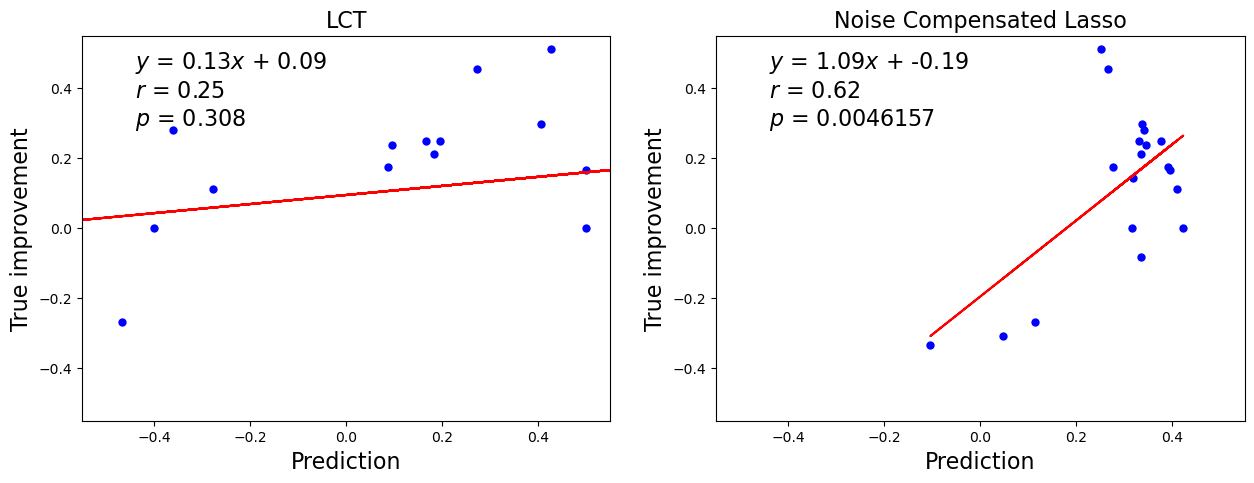

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
# col = np.where(per_change <= 0.3,'orange','blue')
col = 'blue'
ax[0].scatter(pre_imp[m],per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp[m].T,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)
ax[0].set_xlabel('Prediction',fontsize=16)
#col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[1].plot(results_ls_aug,y_model,color='r')
ax[1].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].set_xlabel('Prediction',fontsize=16)
ax[1].set_ylabel('True improvement',fontsize=16)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[1].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([-0.55,0.55])
plt.xlim([-0.55,0.55])
plt.style.use('default')